## Pairs Trading Example. 
* Reproduced here in Python from the example in [Ernie Chans book](https://smile.amazon.com/Algorithmic-Trading-Winning-Strategies-Rationale/dp/1118460146/ref=smi_www_rco2_go_smi_5171374337?_encoding=UTF8&%2AVersion%2A=1&%2Aentries%2A=0&ie=UTF8)



In [ ]:
#Oil, Natural gas, gold,silver, palladium, platinum, copper, 

#but before we brute force this thing, lets make it work locally with a small universe of 
#instruments

#here is the workflow
#choose the data universe you want to operate from
#Choose a list of etfs to pull from

#Implement the actual testing of the pairs
#Find which pairs or basket of products pass the tes
#can you do this in parallel, in the cloud, using Dask

#Backtest the strategy, this you should test on Quantopian

In [67]:
import pandas as pd 
import pandas_datareader.data as web
from statsmodels.tsa.stattools import adfuller as adf
%matplotlib inline
import seaborn as sns
import xarray as xr
import dask as dk
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np




In [68]:
start = datetime(2015, 2, 9)
end = datetime(2018, 12, 12)
uso = web.DataReader('USO', 'iex', start, end)
uco = web.DataReader('UCO', 'iex', start, end)

In [69]:
ewa = web.DataReader('EWA', 'iex', start, end)
ewc = web.DataReader('EWC', 'iex', start, end)
to_plot = pd.DataFrame()
to_plot['ewa'] = ewa['close']
to_plot['ewc'] = ewc['close']

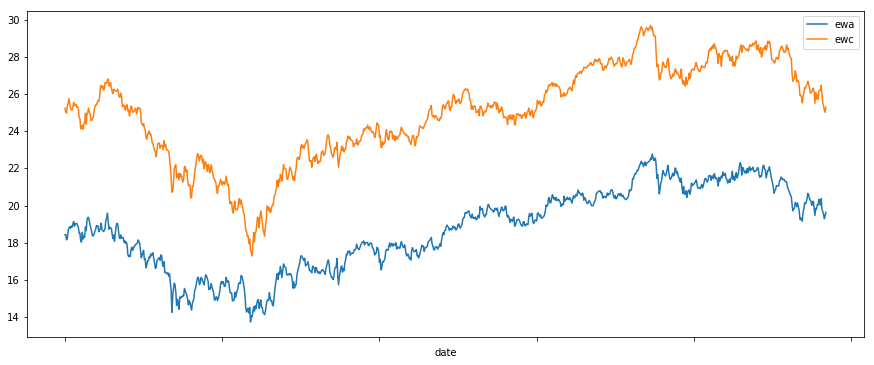

In [70]:

to_plot.plot(label='EWC vs EWA', figsize=(15,6));

## Run Linear Regression switching both series as independent/dependent variable

   * We do not know which of our time series is the independent and which is the dependent variable. 


In [71]:
#fit linear model with both being x and y  
ewa_reshape = to_plot['ewa'].values.reshape((len(to_plot['ewa']), 1))
ewc_reshape = to_plot['ewc'].values.reshape((len(to_plot['ewc']),1))

model1 = linear_model.LinearRegression().fit(ewa_reshape, to_plot['ewc'])
model2 = linear_model.LinearRegression().fit(ewc_reshape, to_plot['ewa'])


In [72]:
model1.coef_

array([1.13587418])

In [73]:
model2.coef_

array([0.81513903])

In [74]:
to_plot['ewc_predicted'] = model1.predict(ewa_reshape)
to_plot['ewa_predicted'] = model2.predict(ewc_reshape)

## Visually inspect the residuals to see if there is evidence of stationarity

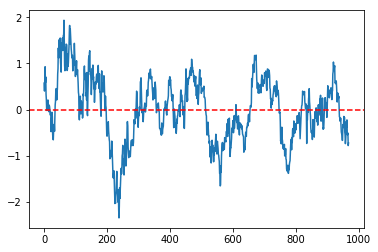

In [80]:
#plot_residuals model1
residuals1 = to_plot['ewc'] - to_plot['ewc_predicted']
plt.plot(np.arange(len(to_plot['ewc'])), (to_plot['ewc'] - to_plot['ewc_predicted']));
plt.axhline(y=0.0, color='r', linestyle='--');

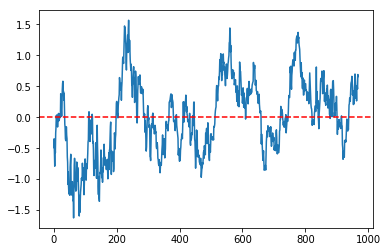

In [79]:
#plot_residuals_model2
residuals2 = to_plot['ewa'] - to_plot['ewa_predicted']
plt.plot(np.arange(len(to_plot['ewa'])), (to_plot['ewa'] - to_plot['ewa_predicted']));
plt.axhline(y=0.0, color='r', linestyle='--');

## Run the Augmented Dickey Fuller Test 
 * Test to see if our time series has a unit root

In [93]:
from arch.unitroot import ADF

##### We can reject the null hypothesis 

In [95]:
#EWA as independent var
adf1 = ADF(residuals1)
print(adf1.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.513
P-value                         0.008
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


##### We can reject the null hypothesis 

In [97]:
#EWC as null hypothesis
adf2 = ADF(residuals2)
print(adf2.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.272
P-value                         0.016
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


* Test-statistic is lower for EWA as independent variable
* We will use this as our linear compbination for future trading